In [1]:
#pip install python-docx

In [2]:
# Necessary imports
import psycopg2
import pandas as pd
from psycopg2 import sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Virtual city tables

In [3]:
# Set the PostgreSQL server parameters
db_username = 's210911'
db_password = '12345'
db_host = 'localhost' 
db_port = 5432
db_database = 'DTU_test'
db_schema = 'virtual_city'
db1_schema = 'demand'
db_table = 'individual'

# Create a connection string
conn_str = f"dbname='{db_database}' user='{db_username}' host='{db_host}' password='{db_password}' port='{db_port}'"

# Establish the connection
conn = psycopg2.connect(conn_str)

# Create a new cursor
cur = conn.cursor()

# Construct SQL queries
query = f'SELECT * FROM "{db_schema}"."{db_table}"'
query_individual10percent = f'SELECT * FROM "{db_schema}"."individual10percent"'
query_individual_lt = f'SELECT * FROM "{db1_schema}"."individual_lt"'
query_taz = f'SELECT * FROM "{db1_schema}"."taz_2012"'
query_das= f'SELECT * FROM "{db1_schema}"."das_calib"'

# Fetch all the rows into a dataframe
df = pd.read_sql_query(query, conn)
df_individual10percent = pd.read_sql_query(query_individual10percent, conn)
df_individual_lt = pd.read_sql_query(query_individual_lt, conn)
df_taz = pd.read_sql_query(query_taz, conn)
df_das = pd.read_sql_query(query_das, conn)


# Close the cursor and the connection
cur.close()
conn.close()

# Kobenhavs Kommune


In [6]:
# Travel time distribution
# Original dataframe
data1 = {
    'Mode': ['Walk', 'Bicycle (only)', 'SUM Car etc.', 'SUM Collective'],
    'Workplace': [0.9, 4.2, 7.6, 5.1],
    'Educational': [0.7, 1.2, 0.6, 1.7],
    'Errands': [6.2, 3.1, 9.1, 2.8],
    'Leisure': [23.0, 5.5, 17.1, 7.3],
    'Business': [0.2, 0.4, 2.2, 0.5]
}
df1 = pd.DataFrame(data1)

# Adjusting the dataframe to combine the modes
ttime_distribution = {
    'Mode': ['Walk', 'Car', 'Public', 'Other'],
    'Work': df1['Workplace'],
    'Education': df1['Educational'],
    'Shop': df1['Errands'],
    'Other': df1['Leisure'] + df1['Business']
}

ttime_distribution = pd.DataFrame(ttime_distribution)
rw_ttime_distribution= ttime_distribution.copy()

# Total trips percentage distribution
# Original dataframe
data2 = {
    'Mode': ['Walk', 'Bicycle (only)', 'SUM Car etc.', 'SUM Collective'],
    'Workplace': [1.1, 4.4, 5.9, 2.4],
    'Educational': [1.5, 2.0, 0.8, 0.7],
    'Errands': [12.5, 5.5, 14.7, 1.7],
    'Leisure': [22.4, 6.3, 11.2, 3.0],
    'Business': [0.5, 0.7, 2.5, 0.2]
}
df2 = pd.DataFrame(data2)

# Adjusting the dataframe to combine the modes
ttrips_distribution = {
    'Mode': ['Walk', 'Car', 'Public', 'Other'],
    'Work': df2['Workplace'],
    'Education': df2['Educational'],
    'Shop': df2['Errands'],
    'Other': df2['Leisure'] + df2['Business']
}

ttrips_distribution = pd.DataFrame(ttrips_distribution)
rw_ttrips_distribution=ttrips_distribution.copy()
def scale_to_100_across_purposes(df):
    total = df.drop(columns='Mode').values.sum()
    for column in df.columns:
        if column != 'Mode':  # skip the 'Mode' column
            df[column] = (df[column] / total) * 100
    return df

rw_ttime_distribution = scale_to_100_across_purposes(rw_ttime_distribution.copy())
rw_ttrips_distribution = scale_to_100_across_purposes(rw_ttrips_distribution.copy())

print(rw_ttime_distribution)
print(rw_ttrips_distribution)

# Save the DataFrame to a csv file
rw_ttime_distribution.to_csv('time_distribution.csv', index=False)
rw_ttrips_distribution.to_csv('trips_distribution].csv', index=False)


     Mode      Work  Education      Shop      Other
0    Walk  0.905433   0.704225  6.237425  23.340040
1     Car  4.225352   1.207243  3.118712   5.935614
2  Public  7.645875   0.603622  9.154930  19.416499
3   Other  5.130785   1.710262  2.816901   7.847082
     Mode  Work  Education  Shop  Other
0    Walk   1.1        1.5  12.5   22.9
1     Car   4.4        2.0   5.5    7.0
2  Public   5.9        0.8  14.7   13.7
3   Other   2.4        0.7   1.7    3.2


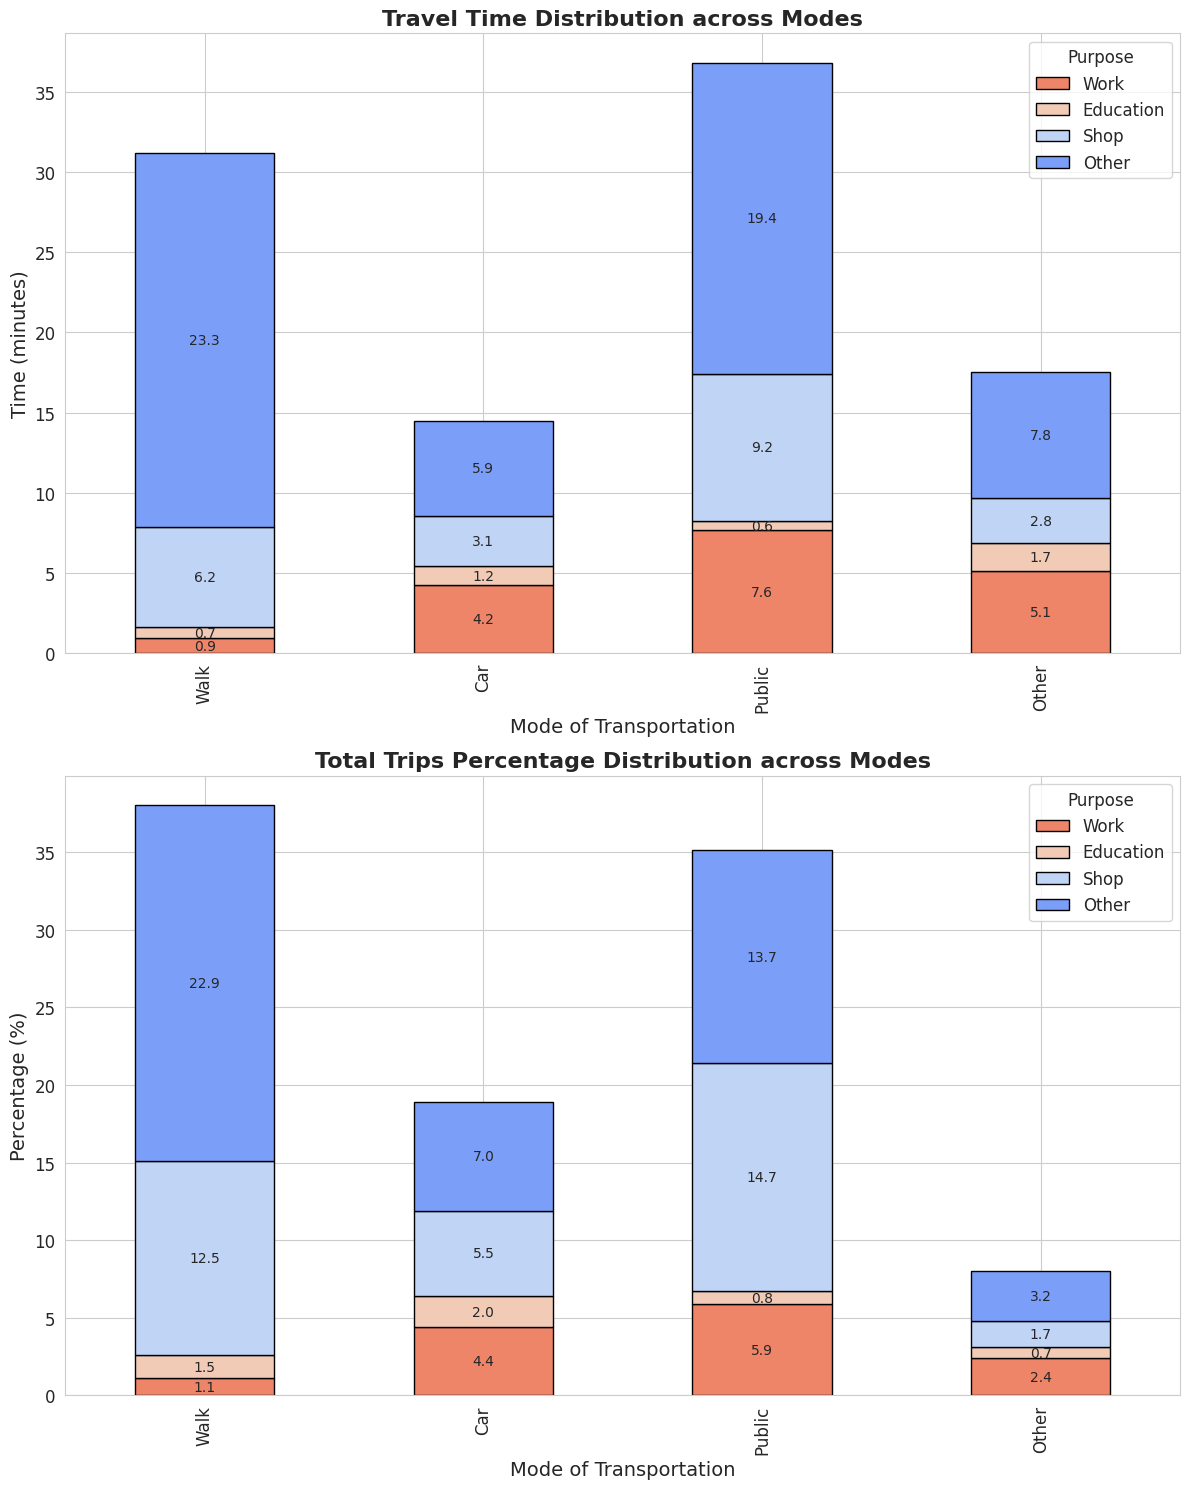

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configure seaborn aesthetics
sns.set_style("whitegrid")

# Set color palette
palette = sns.color_palette("coolwarm_r", 4)

# Travel Time Distribution Visualization
fig, ax = plt.subplots(2, 1, figsize=(12, 15))

# Bar plot for travel time
rw_ttime_distribution.set_index('Mode').plot(kind='bar', stacked=True, ax=ax[0], color=palette, edgecolor='black')
ax[0].set_title('Travel Time Distribution across Modes', fontsize=16, fontweight='bold')
ax[0].set_ylabel('Time (minutes)', fontsize=14)
ax[0].set_xlabel('Mode of Transportation', fontsize=14)
ax[0].legend(title='Purpose', fontsize=12, title_fontsize=12)

# Bar plot for trips distribution
rw_ttrips_distribution.set_index('Mode').plot(kind='bar', stacked=True, ax=ax[1], color=palette, edgecolor='black')
ax[1].set_title('Total Trips Percentage Distribution across Modes', fontsize=16, fontweight='bold')
ax[1].set_ylabel('Percentage (%)', fontsize=14)
ax[1].set_xlabel('Mode of Transportation', fontsize=14)
ax[1].legend(title='Purpose', fontsize=12, title_fontsize=12)

# Improve ticks readability
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    for p in axis.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        axis.text(x + width/2, 
                y + height/2, 
                '{:.1f}'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')
plt.tight_layout()
plt.show()

# Daily activity Schedule (DAS) 

In [9]:
# Calculate travel time for each record
do=df_das.copy()
do['travel_time'] = do['departure_time'] - do['arrival_time']

# Group by tour_type and stop_mode, summing the travel times
df_agg = do.groupby(['tour_type', 'stop_mode']).travel_time.sum().reset_index()

# Map 'tour_type' and 'stop_mode' values
mode_mapping = {
    'Car': 'Car',
    'MRT': 'Public',  
    'Walk':'Walk', 
    'BusTravel': 'Public', 
    'PrivateBus': 'Public', 
    'Car Sharing 2': 'Car',
    'Taxi': 'Car',
    'Car Sharing 3': 'Car', 
    'Motorcycle':'Other', 
}
tour_type_mapping = {
    'Work': 'Work',
    'Education': 'Education',
    'Shop': 'Shop',
    'Other': 'Other',
}

df_agg['stop_mode'] = df_agg['stop_mode'].map(mode_mapping)
df_agg['tour_type'] = df_agg['tour_type'].map(tour_type_mapping)

# Pivot the dataframe to match the target structure
ttime_distribution = df_agg.pivot_table(index='stop_mode', columns='tour_type', values='travel_time', aggfunc='sum').reset_index()

# Rename the column 'stop_mode' to 'Mode'
ttime_distribution.rename(columns={'stop_mode': 'Mode'}, inplace=True)

# Convert the travel times to percentages based on grand total travel time
grand_total_time = ttime_distribution.iloc[:, 1:].sum().sum()
ttime_distribution.iloc[:, 1:] = (ttime_distribution.iloc[:, 1:].div(grand_total_time) * 100).round(2)
ttime_distribution.fillna(0, inplace=True)
as_ttime_distribution = ttime_distribution.copy()
#print(as_ttime_distribution)

# For trip distribution:
do['stop_mode'] = do['stop_mode'].map(mode_mapping)

# Aggregate the data
df_agg = do.groupby(['tour_type', 'stop_mode']).size().reset_index(name='count_trips')

# Pivot the dataframe to match the target structure
ttrips_distribution = df_agg.pivot(index='stop_mode', columns='tour_type', values='count_trips').reset_index()

# Rename the column 'stop_mode' to 'Mode'
ttrips_distribution.rename(columns={'stop_mode': 'Mode'}, inplace=True)

# Compute grand total trips after pivoting
grand_total_trips = ttrips_distribution.iloc[:, 1:].sum().sum()

# Create a copy for percentage calculation
ttrips_distribution_percentage = ttrips_distribution.copy()

# Convert counts into percentages based on grand total trips
for column in ttrips_distribution_percentage.columns:
    if column != 'Mode':
        ttrips_distribution_percentage[column] = (ttrips_distribution_percentage[column] / grand_total_trips * 100).round(4)

ttrips_distribution_percentage.fillna(0, inplace=True)
as_ttrips_distribution = ttrips_distribution_percentage.copy()
#print(as_ttrips_distribution)

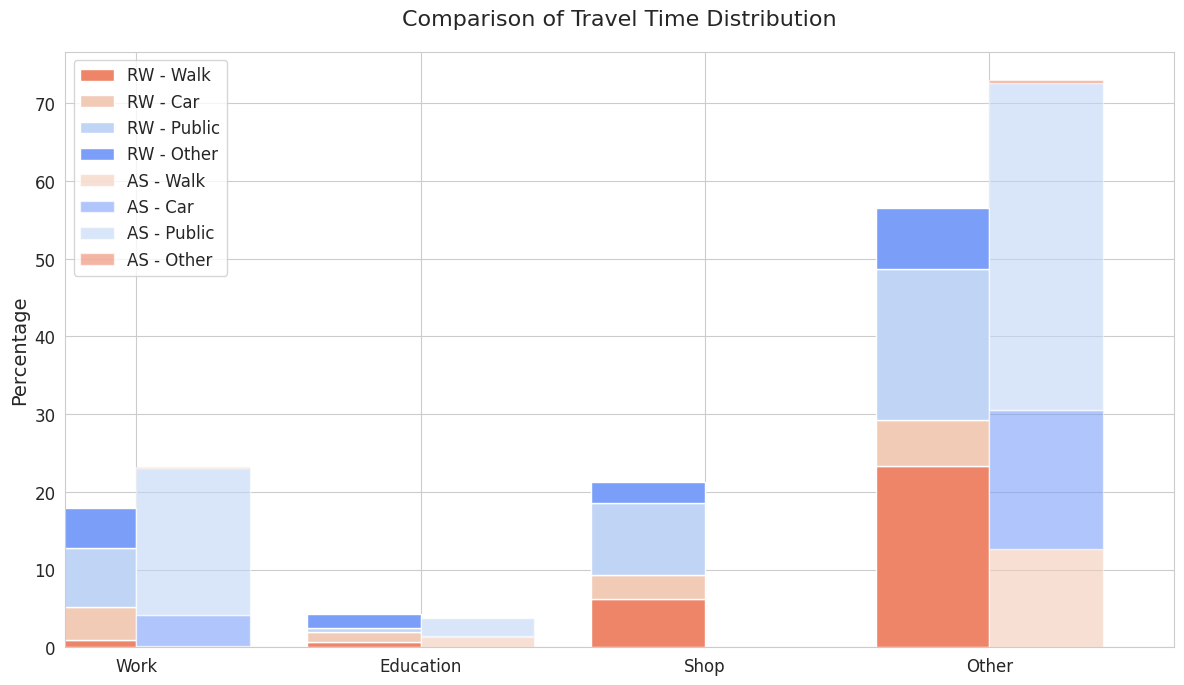

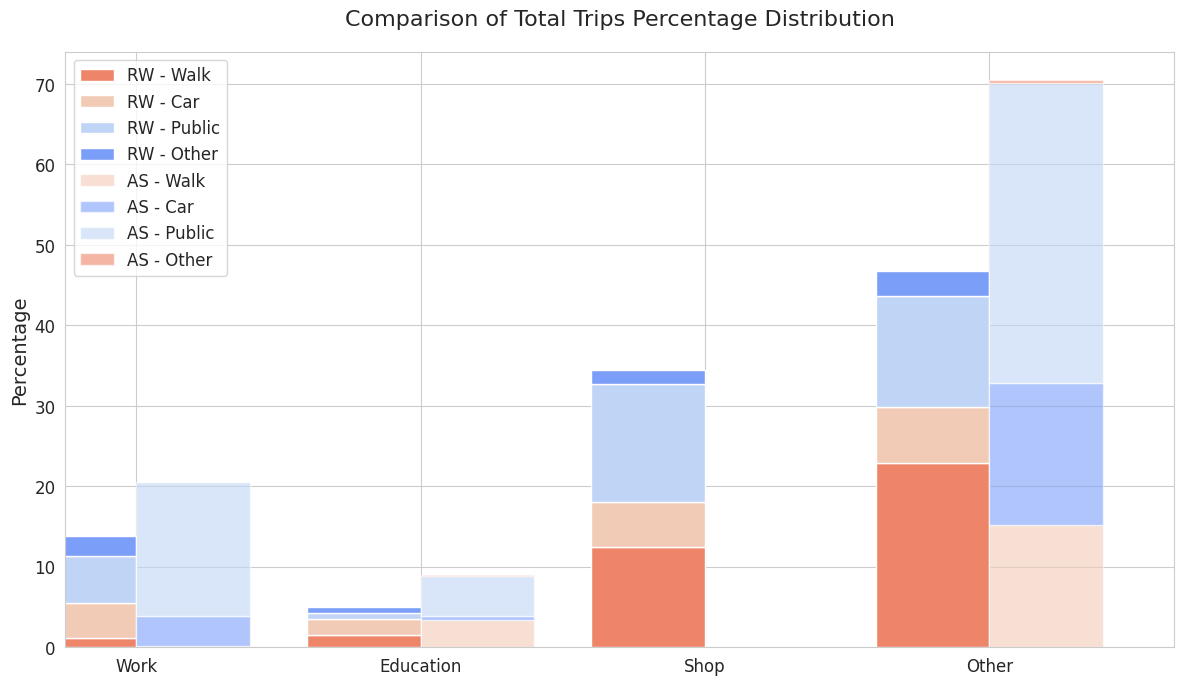

In [10]:
# Styling for our plots
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Using "coolwarm_r" palette
colors = sns.color_palette("coolwarm_r", 4)

# Associate the color palette with the modes
palette = {
    "Walk": colors[0],
    "Car": colors[1],
    "Public": colors[2],
    "Other": colors[3]
}

# Function to create a stacked bar chart comparison
def create_comparison_plot(df1, df2, title, ylabel):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plotting Real World Data
    df1.set_index('Mode').loc[['Walk', 'Car', 'Public', 'Other']].T.plot(kind='bar', stacked=True, ax=ax, position=1, color=[palette[col] for col in df1['Mode']], width=0.4)
    
    # Plotting Other Dataset
    df2.set_index('Mode').loc[['Walk', 'Car', 'Public', 'Other']].T.plot(kind='bar', stacked=True, ax=ax, position=0, color=[palette[col] for col in df2['Mode']], width=0.4, alpha=0.6)
    
    ax.set_title(title, fontsize=16, y=1.03)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel('')
    ax.set_xticklabels(df1.columns[1:], rotation=0, fontsize=12)
    
    # Customizing the legend
    handles, labels = ax.get_legend_handles_labels()
    labels_new = ['RW - Walk', 'RW - Car', 'RW - Public', 'RW - Other', 'AS - Walk', 'AS - Car', 'AS - Public', 'AS - Other']
    ax.legend(handles, labels_new, loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the comparison for both distributions
create_comparison_plot(rw_ttime_distribution, as_ttime_distribution, "Comparison of Travel Time Distribution", "Percentage")
create_comparison_plot(rw_ttrips_distribution, as_ttrips_distribution, "Comparison of Total Trips Percentage Distribution", "Percentage")

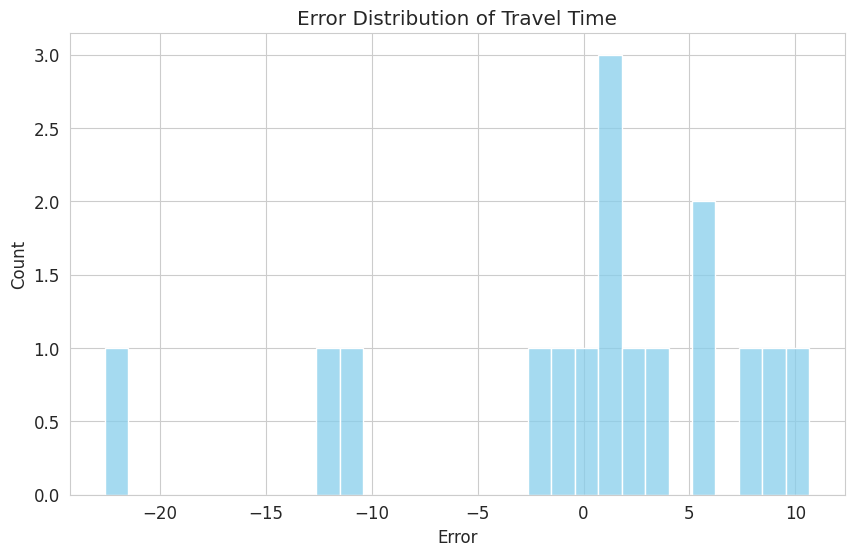

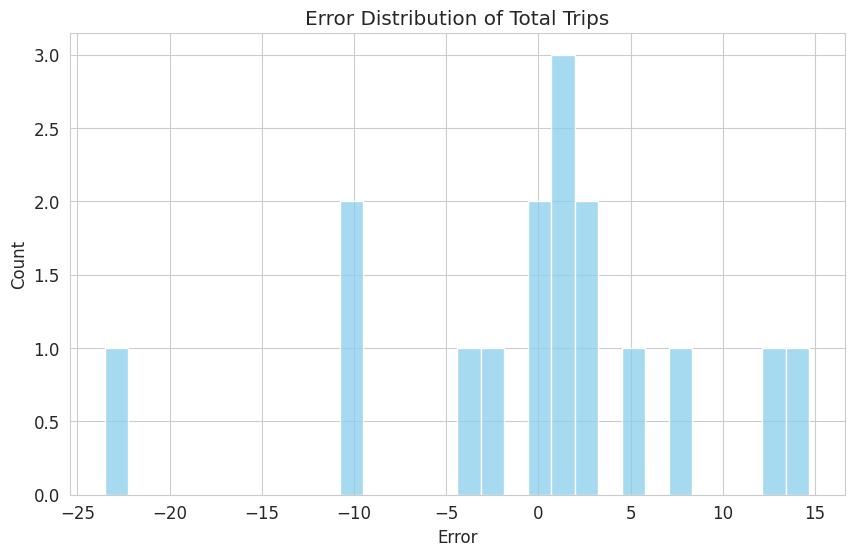

In [11]:
def error_distribution(real_df, sim_df, title):
    """
    Display the histogram of errors between real and simulated dataframes for a given attribute (e.g., travel time).
    
    Parameters:
    - real_df (DataFrame): The dataframe containing the real values.
    - sim_df (DataFrame): The dataframe containing the simulated values.
    - title (str): The title to be displayed on the histogram.
    
    Returns:
    - None: This function will display a histogram and does not return any value.
    """

    # Merge the real and simulated dataframes based on the "Mode" column.
    merged = real_df.merge(sim_df, on="Mode")
    
    # Calculate the error by subtracting simulated values from real values. 
    # '.filter(like='_x')' and '.filter(like='_y')' are used to select columns with suffixes '_x' and '_y' respectively.
    # The suffixes '_x' and '_y' are generated when merging two dataframes having columns with the same names.
    # '_x' refers to columns from the first (left) dataframe and '_y' refers to columns from the second (right) dataframe.
    errors = (merged.filter(like='_x') - merged.filter(like='_y').values).values.flatten()
    
    # Plotting the error distribution.
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, color='skyblue')
    plt.xlabel('Error')
    plt.title(title)
    plt.show()

# Display the error distribution for Travel Time.
error_distribution(rw_ttime_distribution, as_ttime_distribution, "Error Distribution of Travel Time")

# Display the error distribution for Total Trips.
error_distribution(rw_ttrips_distribution, as_ttrips_distribution, "Error Distribution of Total Trips")

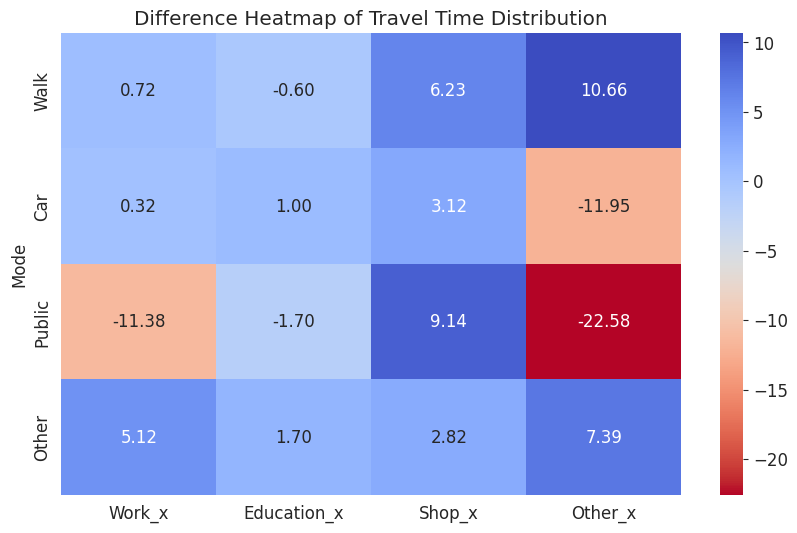

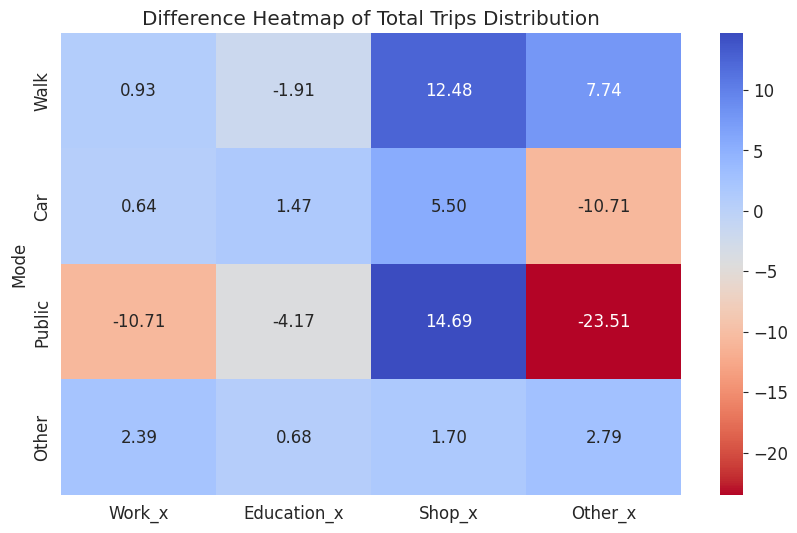

In [12]:
def diff_heatmap(real_df, sim_df, title):
    """
    Display a heatmap representing the difference between real and simulated dataframes for a given attribute.
    
    Parameters:
    - real_df (DataFrame): The dataframe containing the real values.
    - sim_df (DataFrame): The dataframe containing the simulated values.
    - title (str): The title to be displayed on the heatmap.
    
    Returns:
    - None: This function will display a heatmap and does not return any value.
    """

    # Merge the real and simulated dataframes based on the "Mode" column.
    merged = real_df.merge(sim_df, on="Mode")
    
    # Calculate the difference by subtracting simulated values from real values. 
    # '.filter(like='_x')' and '.filter(like='_y')' are used to select columns with suffixes '_x' and '_y' respectively.
    # These suffixes are generated when merging two dataframes having columns with the same names.
    # '_x' refers to columns from the first (left) dataframe and '_y' refers to columns from the second (right) dataframe.
    diff = merged.filter(like='_x') - merged.filter(like='_y').values
    
    # Merging the 'Mode' column back into the 'diff' DataFrame for labeling purposes in the heatmap.
    diff['Mode'] = merged['Mode']
    
    # Plotting the heatmap of differences.
    plt.figure(figsize=(10, 6))
    sns.heatmap(diff.set_index('Mode'), cmap='coolwarm_r', annot=True, fmt='.2f')
    plt.title(title)
    plt.show()

# Display the difference heatmap for Travel Time Distribution.
diff_heatmap(rw_ttime_distribution, as_ttime_distribution, "Difference Heatmap of Travel Time Distribution")

# Display the difference heatmap for Total Trips Distribution.
diff_heatmap(rw_ttrips_distribution, as_ttrips_distribution, "Difference Heatmap of Total Trips Distribution")

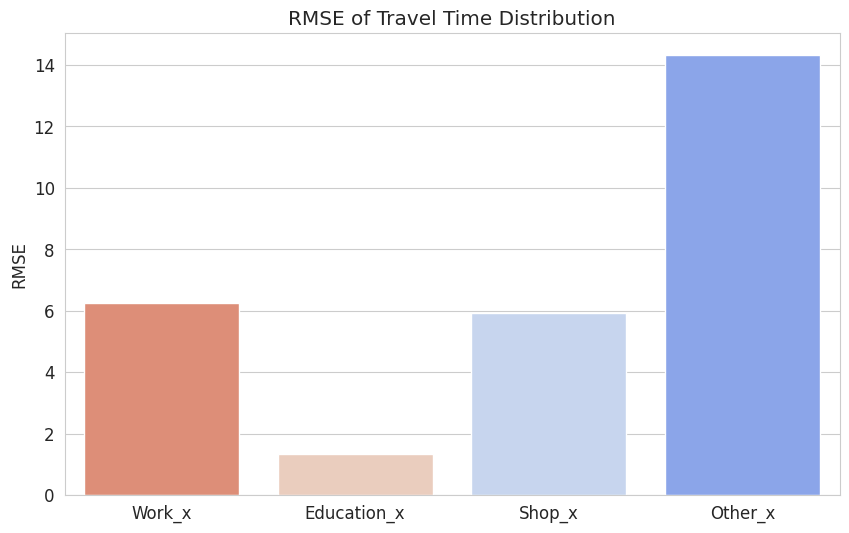

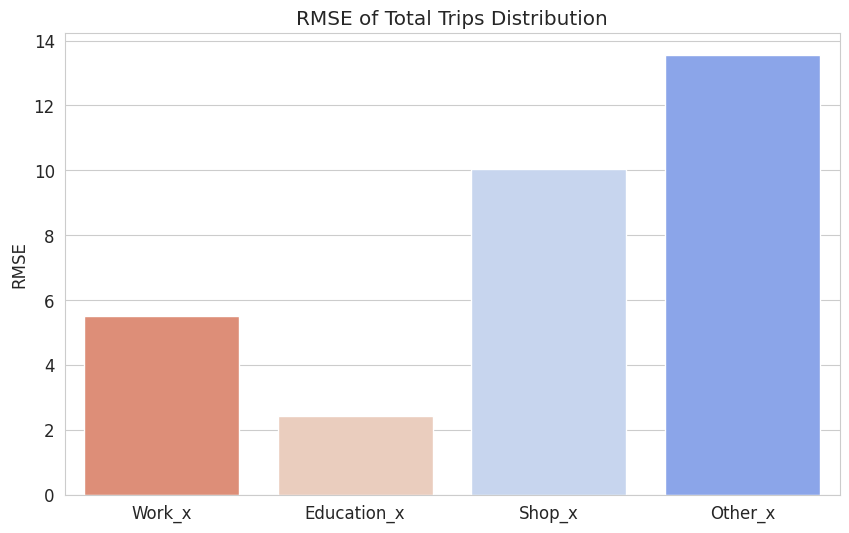

In [13]:
def rmse_barplot(real_df, sim_df, title):
    merged = real_df.merge(sim_df, on="Mode")
    errors = (merged.filter(like='_x') - merged.filter(like='_y').values)**2
    rmse_vals = np.sqrt(errors.mean())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rmse_vals.index, y=rmse_vals.values, palette=colors)
    plt.ylabel('RMSE')
    plt.title(title)
    plt.show()

rmse_barplot(rw_ttime_distribution, as_ttime_distribution, "RMSE of Travel Time Distribution")
rmse_barplot(rw_ttrips_distribution, as_ttrips_distribution, "RMSE of Total Trips Distribution")

In [14]:
# Calculate RMSE
def calculate_rmse(real_df, sim_df):
    """
    Calculate Root Mean Squared Error (RMSE) between real and simulated dataframes.
    
    Parameters:
    - real_df (DataFrame): The dataframe containing the real values.
    - sim_df (DataFrame): The dataframe containing the simulated values.
    
    Returns:
    - float: The computed RMSE.
    """
    
    # Merge the real and simulated dataframes based on the "Mode" column to ensure alignment.
    merged = real_df.merge(sim_df, on="Mode")
    
    # Calculate the squared differences.
    # Columns with suffixes '_x' are from 'real_df' and '_y' are from 'sim_df'.
    squared_diffs = (merged.filter(like='_x') - merged.filter(like='_y').values)**2
    
    # Calculate the Mean Squared Error (MSE) by averaging squared differences across all columns and rows.
    mse = squared_diffs.mean().mean()
    
    # Return the square root of MSE which gives RMSE.
    return np.sqrt(mse)

# Calculate RMSE for Travel Time Distribution and Total Trips Distribution.
travel_time_rmse = calculate_rmse(rw_ttime_distribution, as_ttime_distribution)
total_trips_rmse = calculate_rmse(rw_ttrips_distribution, as_ttrips_distribution)

# Specify importance weights to give more priority to one metric over another.
# In this example, travel_time is given 2/3 weight and total_trips is given 1/3 weight.
importance_weights = [2/3, 1/3]

# Calculate the weighted error by multiplying individual RMSEs with their respective importance weights and summing them.
weighted_error = importance_weights[0] * travel_time_rmse + importance_weights[1] * total_trips_rmse

# Copy the weighted error value to inadequacy for clarity.
# This step might not be necessary if 'weighted_error' and 'inadequacy' are interchangeable in your context.
inadequacy = weighted_error.copy()

print("Inadequacy:", inadequacy)

Inadequacy: 8.576890200751581


In [ ]:
# Group by stop_type and then plot a histogram of arrival times for each type
for stop_type in df_das['stop_type'].unique():
    df_das[df_das['stop_type'] == stop_type]['arrival_time'].hist(alpha=0.5, bins=24, label=stop_type)

plt.title('Distribution of activity start times for different activities')
plt.xlabel('Hour of day')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Plotting the frequency of each tour type
df_das['tour_type'].value_counts().plot(kind='bar', title='Distribution of Tour Types')
plt.show()

# Plotting the frequency of each stop type
df_das['stop_type'].value_counts().plot(kind='bar', title='Distribution of Stop Types')
plt.show()